In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt

In [33]:
# Reads 'features_gB4.csv', splits into 70/20/10, fits PCA on training set only
# applies transform to validation and test sets, and saves reduced CSVs

INPUT = Path("features_gB4.csv")
OUT_TRAIN = Path("train_reduced_gB4.csv")
OUT_VAL = Path("validation_reduced_gB4.csv")
OUT_TEST = Path("test_reduced_gB4.csv")
RANDOM_STATE = 42

# Load
df = pd.read_csv(INPUT)

# Keep numeric features only (drop non-numeric columns)
X = df.select_dtypes(include=[np.number])
if X.shape[1] == 0:
    raise SystemExit("No numeric features found in features_gB4.csv")

# Split 70% train, 20% val, 10% test
X_train, X_temp = train_test_split(X, test_size=0.30, random_state=RANDOM_STATE, shuffle=True)
# From the 30% temp, split so test is 1/3 of temp => 10% of total
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=RANDOM_STATE, shuffle=True)


Elbow point is at component 2 (eigenvalue: 396.2164)


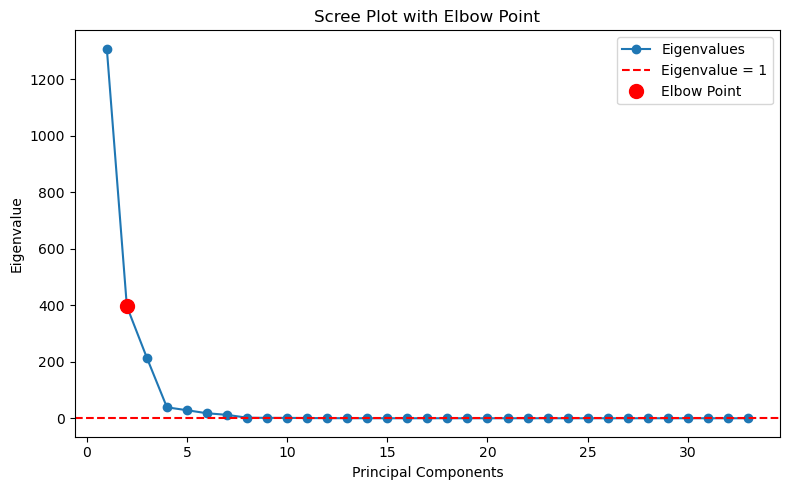

Variance ratio 95%: 4 components, eigenvalue at cutoff: 38.7156
Variance ratio 90%: 3 components, eigenvalue at cutoff: 213.8741
Variance ratio 85%: 3 components, eigenvalue at cutoff: 213.8741
Variance ratio 80%: 2 components, eigenvalue at cutoff: 396.2164


In [ ]:
# Scree plot
pca_full = PCA()
pca_full.fit(X_train)
eigenvalues = pca_full.explained_variance_

# Robust elbow (knee) detection using the distance to line method
def find_elbow_knee(eigenvalues):
    n_points = len(eigenvalues)
    all_coords = np.vstack((np.arange(n_points), eigenvalues)).T
    first_point = all_coords[0]
    last_point = all_coords[-1]
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_on_line = np.outer(scalar_product, line_vec_norm)
    distance_to_line = np.sqrt(np.sum((vec_from_first - vec_on_line) ** 2, axis=1))
    elbow_idx = np.argmax(distance_to_line)
    return elbow_idx

elbow_idx = find_elbow_knee(eigenvalues)
print(f"Robust elbow point is at component {elbow_idx + 1} (eigenvalue: {eigenvalues[elbow_idx]:.4f})")

# Plot scree plot with robust elbow point highlighted
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', label='Eigenvalues')
plt.axhline(1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.plot(elbow_idx + 1, eigenvalues[elbow_idx], 'go', markersize=10, label='Robust Elbow Point')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot with Robust Elbow Point')
plt.legend()
plt.tight_layout()
plt.show()

# Print number of principal components and eigenvalues for different explained variance ratios
for ratio in [0.95, 0.90, 0.85, 0.80]:
    pca_tmp = PCA(n_components=ratio, svd_solver="full")
    pca_tmp.fit(X_train)
    n_comp = pca_tmp.n_components_
    eig = eigenvalues[n_comp-1] if n_comp-1 < len(eigenvalues) else None
    print(f"Variance ratio {int(ratio*100)}%: {n_comp} components, eigenvalue at cutoff: {eig:.4f}")

#apply the best variance ratio as found by the scree plot
PCA_VARIANCE = elbow_idx

In [ ]:
# Fit PCA on training set only
pca = PCA(n_components=PCA_VARIANCE, svd_solver="full")
pca.fit(X_train)

# Transform datasets
X_train_red = pca.transform(X_train)
X_val_red = pca.transform(X_val)
X_test_red = pca.transform(X_test)


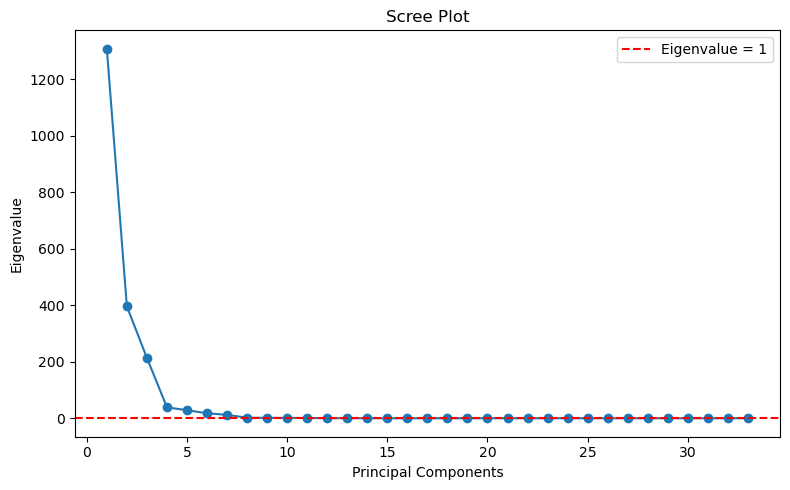

Variance ratio 95%: 4 components, eigenvalue at cutoff: 38.7156
Variance ratio 90%: 3 components, eigenvalue at cutoff: 213.8741
Variance ratio 85%: 3 components, eigenvalue at cutoff: 213.8741
Variance ratio 80%: 2 components, eigenvalue at cutoff: 396.2164


In [35]:
# Make DataFrames with PC column names
n_comp = X_train_red.shape[1]
cols = [f"PC{i+1}" for i in range(n_comp)]
pd.DataFrame(X_train_red, columns=cols).to_csv(OUT_TRAIN, index=False)
pd.DataFrame(X_val_red, columns=cols).to_csv(OUT_VAL, index=False)
pd.DataFrame(X_test_red, columns=cols).to_csv(OUT_TEST, index=False)

In [36]:
# Scales data for standardization and writes it back to the same files

# Load data
train = pd.read_csv('train_reduced_gB4.csv')
validation = pd.read_csv('validation_reduced_gB4.csv')
test = pd.read_csv('test_reduced_gB4.csv')

# Fit scaler on train data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
validation_scaled = scaler.transform(validation)
test_scaled = scaler.transform(test)

# Convert back to DataFrame, preserving column names
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns)
validation_scaled_df = pd.DataFrame(validation_scaled, columns=validation.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns)

# Save the scaled data
train_scaled_df.to_csv('train_reduced_gB4.csv', index=False)
validation_scaled_df.to_csv('validation_reduced_gB4.csv', index=False)
test_scaled_df.to_csv('test_reduced_gB4.csv', index=False)